# THIS IS FOR CLASS IOU DURING TRAINING

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import wandb

wandb.login()
api = wandb.Api()

wandb: Currently logged in as: gooogleon (gooogleon-uni-hd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
RUN_NAMES = [
    "Incr",
    "Incr_Gen_Base",
    # "Incr_Gen_MRTE",
    # "Incr_Gen_Cap",
    # "Incr_Gen_Cap_Large",
    # "Incr_Gen_Cap_Large_RR",
    "Incr_Gen_Base_RR",
    # "Incr_Gen_MRTE_RR",
    # "Incr_Gen_Base_Large_RR",
    # "Incr_Gen_MRTE_Large_RR",
    # "Incr_Gen_Better_Cap_RR",
    # "Incr_Gen_Better_Cap_Large_RR",
    "Incr_Gen_Lora_RR",
    "Incr_Gen_Lora_Large_RR",
    "Incr_Gen_VOC_RR",
    "Incr_Gen_Lora_Inpainting_RR",
    "Incr_Gen_Lora_Inpainting_Large_RR",
    "Incr_Gen_Lora_Better_Inpainting_RR",
    "Incr_Gen_Lora_Better_Inpainting_Large_RR",
]

BASE_RUNS = [
    "Base"
]

In [3]:
runs = api.runs("gooogleon-uni-hd/WILSON")

dj_runs = {"_".join(run.name.split("_")[1:]): run for run in runs if ("_".join(run.name.split("_")[1:]) in RUN_NAMES and "ov" not in run.name)}
ov_runs = {"_".join(run.name.split("_")[1:]): run for run in runs if ("_".join(run.name.split("_")[1:]) in RUN_NAMES and "ov" in run.name)}

dj_base = list({"_".join(run.name.split("_")[1:]): run for run in runs if ("_".join(run.name.split("_")[1:]) in BASE_RUNS and "ov" not in run.name)}.values())[0]
ov_base = list({"_".join(run.name.split("_")[1:]): run for run in runs if ("_".join(run.name.split("_")[1:]) in BASE_RUNS and "ov" in run.name)}.values())[0]

# assert len(dj_runs) == len(ov_runs) == len(RUN_NAMES)

In [4]:
def get_path(id):
    for run_dir in os.listdir("/home/thesis/marx/wilson_gen/WILSON/wandb"):
        if id in run_dir:
            return f"/home/thesis/marx/wilson_gen/WILSON/wandb/{run_dir}"
    raise ValueError(f"Run {id} not found")

In [5]:
def get_data(run_dict):
    all_old_means = np.zeros((len(run_dict), 20))
    all_new_means = np.zeros((len(run_dict), 20))
    all_tot_means = np.zeros((len(run_dict), 20))
    run_names_existing = []
    i = 0
    for run_name in RUN_NAMES:
        # print(run_name)
        try:
            run = run_dict[run_name]
        except KeyError:
            print(f"Run {run_name} not found")
            continue
        old_means = np.zeros(20)
        new_means = np.zeros(20)
        tot_means = np.zeros(20)
        counter = 0
        for row in run.scan_history():
            try:
                if row["Val/Class_IoU/1/1"] is not None:
                    # print(row["Val/Class_IoU/1/1"]["path"])
                    log_path = get_path(run.id)
                    log_path += f"/files/{row["Val/Class_IoU/1/1"]["path"]}"
                    # print(log_path)
                    with open(log_path, "r") as f:
                        data = json.load(f)["data"][0][1:]
                    old_mean = np.mean(data[:10])
                    new_mean = np.mean(data[10:])
                    tot_mean = np.mean(data)
                    old_means[counter] = old_mean
                    new_means[counter] = new_mean
                    tot_means[counter] = tot_mean
                    counter += 1
            except Exception as e:
                # print(e)
                pass
        # assert counter == 20, f"Counter is {counter}"
        if counter == 20:
            all_old_means[i] = old_means
            all_new_means[i] = new_means
            all_tot_means[i] = tot_means
            i += 1
            run_names_existing.append(run_name)
        else:
            print(f"Run {run_name} has only {counter} values -> skipping")
    return all_old_means, all_new_means, all_tot_means, run_names_existing

def get_base_data(base_run):
    old_means = np.zeros(15)
    counter = 0
    for row in base_run.scan_history():
        if row["Val/MeanIoU/0"] is not None:
            old_means[counter] = row["Val/MeanIoU/0"]
            counter += 1
    assert counter == 15, f"Counter is {counter}"
    return old_means

In [6]:
old_dj, new_dj, tot_dj, run_names_existing_dj = get_data(dj_runs)
old_base_dj = get_base_data(dj_base)

Run Incr_Gen_Lora_Inpainting_RR not found
Run Incr_Gen_Lora_Inpainting_Large_RR not found
Run Incr_Gen_Lora_Better_Inpainting_RR not found
Run Incr_Gen_Lora_Better_Inpainting_Large_RR not found


In [7]:
old_ov, new_ov, tot_ov, run_names_existing_ov = get_data(ov_runs)
old_base_ov = get_base_data(ov_base)

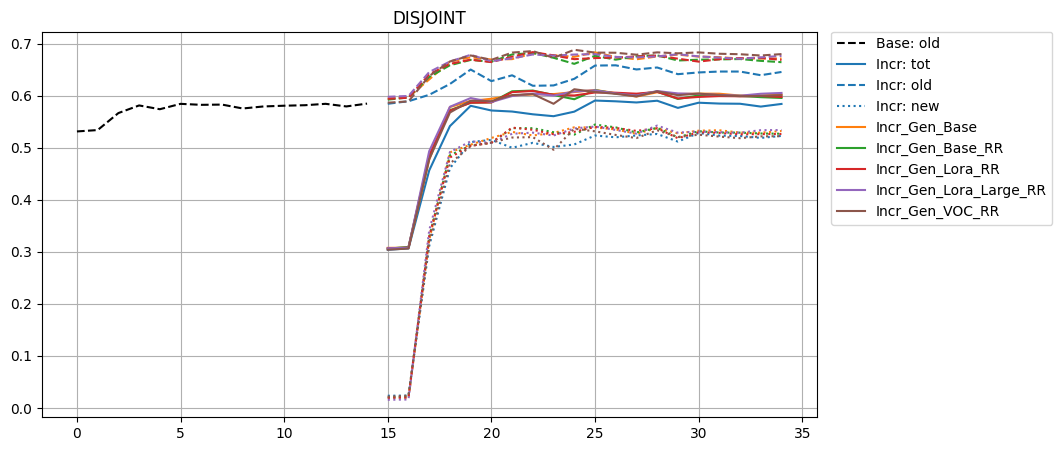

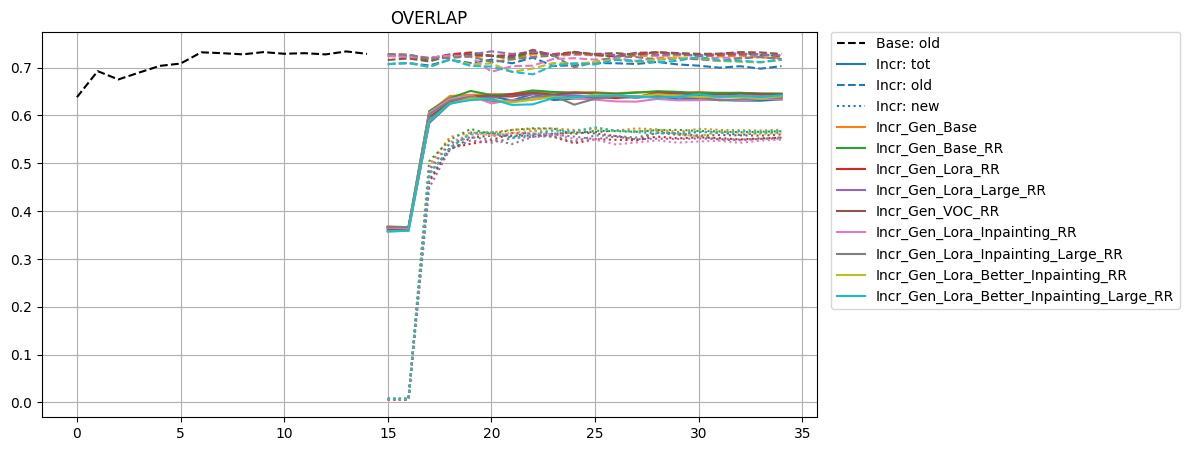

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(15), old_base_dj, label="Base: old", color="k", ls="--")
for i, run_name in enumerate(run_names_existing_dj):
    if i == 0:
        plt.plot(np.arange(15, 35, 1), tot_dj[i], color=f"C{i}", label=run_name+": tot")
        plt.plot(np.arange(15, 35, 1), old_dj[i], color=f"C{i}", ls="--", label=run_name+": old")
        plt.plot(np.arange(15, 35, 1), new_dj[i], color=f"C{i}", ls=":", label=run_name+": new")
    else:
        plt.plot(np.arange(15, 35, 1), tot_dj[i], color=f"C{i}", label=run_name)
        plt.plot(np.arange(15, 35, 1), old_dj[i], color=f"C{i}", ls="--")
        plt.plot(np.arange(15, 35, 1), new_dj[i], color=f"C{i}", ls=":")
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.title("DISJOINT")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(15), old_base_ov, label="Base: old", color="k", ls="--")
for i, run_name in enumerate(run_names_existing_ov):
    if i == 0:
        plt.plot(np.arange(15, 35, 1), tot_ov[i], color=f"C{i}", label=run_name+": tot")
        plt.plot(np.arange(15, 35, 1), old_ov[i], color=f"C{i}", ls="--", label=run_name+": old")
        plt.plot(np.arange(15, 35, 1), new_ov[i], color=f"C{i}", ls=":", label=run_name+": new")
    else:
        plt.plot(np.arange(15, 35, 1), tot_ov[i], color=f"C{i}", label=run_name)
        plt.plot(np.arange(15, 35, 1), old_ov[i], color=f"C{i}", ls="--")
        plt.plot(np.arange(15, 35, 1), new_ov[i], color=f"C{i}", ls=":")
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.title("OVERLAP")
plt.grid()
plt.show()

# FORGETTING DOES NOT SEEM TO BE A BIG PROBLEM, AS EVEN WILSON IMPROVES FOR DISJOINT AND STAYS THE SAME FOR OVERLAP.